In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pybedtools as pb
import numpy as np
from scipy import stats
import pandas as pd
font = {'family' : 'sans-serif',
        'weight' : 'light',
        'size'   : '12'}

plt.rc('font', **font)

# Gene expression associated with TDG-WT / TDG-KO specific 5fC-nucleosomes, within a given tissue (heart or hindbrain)


Compute the distribution of logFC and RPKMs from RNA-seq derived differential expression (DE) for genes associated with tissue specific enhancers between TDG-WT and TDG-KO, and a subset of those that have enhancers overlapping with tissue-unique 5fC-containing nucleosomes.

The list of enhancer location and their associtate genes was taken from Suppl. Table 7 in  doi:10.1038/nature11243, also available from Mouse Encode Project at Ren Lab (http://chromosome.sdsc.edu/mouse/download.html).  
Each enhancer site was considered to span +/-1.5 Kb around the center of the predicted enhancer. These files have been named `mm9_enhancer_brain_slop_1500.bed` and `mm9_enhancer_heart_slop_1500.bed`.

This notebook requires the following datasets, 

- `expr_diff.ko_vs_wt_brain.edgeR.txt` and `expr_diff.ko_vs_wt_heart.edgeR.txt`, `expr_diff.brain_vs_heart_ko.edgeR.txt`, `expr_diff.brain_vs_heart_wt.edgeR.txt`, `rpkm_brain_heart_wt_and_ko.txt`, which can be obtained following 
the protocol described [here](https://github.com/sblab-bioinformatics/5fC-nucleosome/blob/master/RNA-seq/README.md).
- `5fC_consensus_brain_WT.bed.gz`, `5fC_consensus_brain_ko.bed.gz`, `5fC_heart_consensus_WT.bed.gz`, `5fC_heart_consensus_KO.bed.gz`, which can be obtained following the protocols described [here](https://github.com/sblab-bioinformatics/5fC-nucleosome/blob/master/5fC_sites_in_heart_brain_WT_and_TDG_KO/README.md).
- `ConsensusNucleosome_iNPS_Brain_WT_noMT.bed`, `ConsensusNucleosome_iNPS_Heart_WT_noMT.bed`, `ConsensusNucleosome_iNPS_Brain_KO_noMT.bed`, `ConsensusNucleosome_iNPS_Heart_KO_noMT.bed`, which can be obtained following the protocols described [here](https://github.com/sblab-bioinformatics/5fC-nucleosome/blob/master/MNase-seq/README.md).

---
Function that creates a dictionary of DE genes and their associated logFC, you can choose to filter by FDR<0.05 or not.

In [2]:
def dict_expression(edgeR_fname, FDR=True):
    dict_exp = {}
    
    with open(edgeR_fname, "r") as fo:
        for l in fo.read().splitlines():
            if l.split("\t")[0] != "gene_id":
                gene_name = l.split("\t")[1]
                fdr = float(l.split("\t")[-2])
                logF = float(l.split("\t")[2])
                if "," in gene_name:
                    for test in gene_name.split(","): 
                        if fdr < 0.05 or not FDR:
                            dict_exp.setdefault(test.upper(),logF) 
                    #print gene_name, fdr
                else:
                    if fdr < 0.05 or not FDR:
                        dict_exp.setdefault(gene_name.upper(),logF)


    return dict_exp

In [3]:
# Handy functions to generate a list of genes associated with a given 
# bed file (bed_file) that are in a dictionary (expr)
def find_genes_DE_inbed(bed_file, expr):
    for b in bed_file:
        if b.name.upper() in expr:
            yield b.name
            
def find_DE_inbed(bed_file, expr):
    for b in bed_file:
        if b.name.upper() in expr:
            yield expr[b.name.upper()]

# TDG WT vs KO in Heart and Brain

In [4]:
expr_brain_ko_vs_wt = dict_expression("expr_diff.ko_vs_wt_brain.edgeR.txt")
expr_heart_ko_vs_wt = dict_expression("expr_diff.ko_vs_wt_heart.edgeR.txt")
expr_brain_vs_heart_ko = dict_expression("expr_diff.brain_vs_heart_ko.edgeR.txt")
expr_brain_vs_heart_wt = dict_expression("expr_diff.brain_vs_heart_wt.edgeR.txt")
# No FDR
all_expr_brain_ko_vs_wt = dict_expression("expr_diff.ko_vs_wt_brain.edgeR.txt", FDR=False)
all_expr_heart_ko_vs_wt = dict_expression("expr_diff.ko_vs_wt_heart.edgeR.txt", FDR=False)
all_expr_brain_vs_heart_ko = dict_expression("expr_diff.brain_vs_heart_ko.edgeR.txt", FDR=False)
all_expr_brain_vs_heart_wt = dict_expression("expr_diff.brain_vs_heart_wt.edgeR.txt", FDR=False)

In [5]:
print("Number of DE genes Brain KO_vs_WT", len(expr_brain_ko_vs_wt))
print("Number of DE genes Heart KO_vs_WT", len(expr_heart_ko_vs_wt))
print("Number of DE genes Brain vs Heart WT", len(expr_brain_vs_heart_wt))
print("Number of DE genes Brain vs Heart KO", len(expr_brain_vs_heart_ko))
print()
print("Number of total genes Brain KO_vs_WT", len(all_expr_brain_ko_vs_wt))
print("Number of total genes Heart KO_vs_WT", len(all_expr_heart_ko_vs_wt))
print("Number of total genes Brain vs Heart WT", len(all_expr_brain_vs_heart_wt))
print("Number of total genes Brain vs Heart KO", len(all_expr_brain_vs_heart_ko))

Number of DE genes Brain KO_vs_WT 87
Number of DE genes Heart KO_vs_WT 188
Number of DE genes Brain vs Heart WT 4036
Number of DE genes Brain vs Heart KO 3100

Number of total genes Brain KO_vs_WT 14415
Number of total genes Heart KO_vs_WT 13286
Number of total genes Brain vs Heart WT 13286
Number of total genes Brain vs Heart KO 13286


# Number of DE genes for which we have enhancer annotation Brain/Heart

In [6]:
## These one-column text file simply contain unique gene names found in the Ren Lab list of brain/heart enhancers
genes_enhancer_brain = np.genfromtxt("genes_in_enhancer_brain.txt", dtype="str")
genes_enhancer_heart = np.genfromtxt("genes_in_enhancer_heart.txt", dtype="str")

Create a list containing the logFC for all genes present in the Ren Lab list of 
enhancers, both for brain and heart 

In [7]:
de_enhancer_brain_wt_ko = set()
for g in genes_enhancer_brain:
    if g.upper() in expr_brain_ko_vs_wt:
        de_enhancer_brain_wt_ko.add(expr_brain_ko_vs_wt[g.upper()])
de_enhancer_heart_wt_ko = set()
for g in genes_enhancer_heart:
    if g.upper() in expr_heart_ko_vs_wt:
        de_enhancer_heart_wt_ko.add(expr_heart_ko_vs_wt[g.upper()])

# All DE genes (KO vs WT, FDR<0.05) in Nucleosome-5fC (nucleosome in 5fC peak f=0.8) 

In [12]:
# Built intersection. Start by reading in the bed files
# 5fC
cons_5fC_brain_wt = pb.BedTool("5fC_consensus_brain_WT.bed.gz")
cons_5fC_brain_ko = pb.BedTool("5fC_consensus_brain_ko.bed.gz")
cons_5fC_heart_wt = pb.BedTool("5fC_heart_consensus_WT.bed.gz")
cons_5fC_heart_ko = pb.BedTool("5fC_heart_consensus_KO.bed.gz")
# Nuc
cons_nuc_brain_ko = pb.BedTool("ConsensusNucleosome_iNPS_Brain_KO_noMT.bed")
cons_nuc_brain_wt = pb.BedTool("ConsensusNucleosome_iNPS_Brain_WT_noMT.bed")
cons_nuc_heart_wt = pb.BedTool("ConsensusNucleosome_iNPS_Heart_WT_noMT.bed")
cons_nuc_heart_ko = pb.BedTool("ConsensusNucleosome_iNPS_Heart_KO_noMT.bed")

In [13]:
# ko intersection, nucleosome in 5fC f=0.9
nuc_5fC_brain_ko = cons_nuc_brain_ko.intersect(cons_5fC_brain_ko, f=0.8)
nuc_5fC_heart_ko = cons_nuc_heart_ko.intersect(cons_5fC_heart_ko, f=0.8)
print("Brain  KO", len(nuc_5fC_brain_ko))
print("Heart KO", len(nuc_5fC_heart_ko))
nuc_5fC_brain_wt = cons_nuc_brain_wt.intersect(cons_5fC_brain_wt, f=0.8)
nuc_5fC_heart_wt = cons_nuc_heart_wt.intersect(cons_5fC_heart_wt, f=0.8)
print("Brain  WT", len(nuc_5fC_brain_wt))
print("Heart WT", len(nuc_5fC_heart_wt))

Brain  KO 57183
Heart KO 92298
Brain  WT 2127
Heart WT 560


In [14]:
# intersect with enhancers Ren Lab
enhancers_heart = pb.BedTool("mm9_enhancer_heart_slop_1500.bed")
enhancers_brain = pb.BedTool("mm9_enhancer_brain_slop_1500.bed")

In [15]:
#KO
enhancers_nuc5fc_h_ko = enhancers_heart.intersect(nuc_5fC_heart_ko)
enhancers_nuc5fc_b_ko = enhancers_brain.intersect(nuc_5fC_brain_ko)

enhancers_not_nuc5fc_h_ko = enhancers_heart.intersect(nuc_5fC_heart_ko, v=True)
enhancers_not_nuc5fc_b_ko = enhancers_brain.intersect(nuc_5fC_brain_ko, v=True)


# WT
enhancers_nuc5fc_h_wt = enhancers_heart.intersect(nuc_5fC_heart_wt)
enhancers_nuc5fc_b_wt = enhancers_brain.intersect(nuc_5fC_brain_wt)

enhancers_not_nuc5fc_h_wt = enhancers_heart.intersect(nuc_5fC_heart_wt, v=True)
enhancers_not_nuc5fc_b_wt = enhancers_brain.intersect(nuc_5fC_brain_wt, v=True)

# print
print("Brain nuc5fC WT", len(enhancers_nuc5fc_b_wt))
print("Brain nuc5fC KO", len(enhancers_nuc5fc_b_ko))
print("Brain NOT nuc5fC WT", len(enhancers_not_nuc5fc_b_wt))
print("Brain NOT nuc5fC KO", len(enhancers_not_nuc5fc_b_ko))

print()
print("Heart nuc5fC WT", len(enhancers_nuc5fc_h_wt))
print("Heart nuc5fC KO", len(enhancers_nuc5fc_h_ko))
print("Heart NOT nuc5fC WT", len(enhancers_not_nuc5fc_h_wt))
print("Heart NOT nuc5fC KO", len(enhancers_not_nuc5fc_h_ko))

Brain nuc5fC WT 642
Brain nuc5fC KO 12287
Brain NOT nuc5fC WT 35026
Brain NOT nuc5fC KO 25982

Heart nuc5fC WT 106
Heart nuc5fC KO 32950
Heart NOT nuc5fC WT 48081
Heart NOT nuc5fC KO 28760


In [16]:
# Heart
logfc_h_5fC_nuc_de = list((find_DE_inbed(enhancers_nuc5fc_h_ko, 
                                        expr_heart_ko_vs_wt)))
logfc_h_not_5fC_nuc_de = list((find_DE_inbed(enhancers_not_nuc5fc_h_ko, 
                                            expr_heart_ko_vs_wt)))
# Brain 
logfc_b_5fC_nuc_de = list((find_DE_inbed(enhancers_nuc5fc_b_ko, 
                                        expr_brain_ko_vs_wt)))
logfc_b_not_5fC_nuc_de = list((find_DE_inbed(enhancers_not_nuc5fc_b_ko, 
                                            expr_brain_ko_vs_wt)))

In [17]:
print("Brain DE 5fC-nuc", len(logfc_b_5fC_nuc_de))
print("Heart DE 5fC-nuc", len(logfc_h_5fC_nuc_de))

Brain DE 5fC-nuc 40
Heart DE 5fC-nuc 220


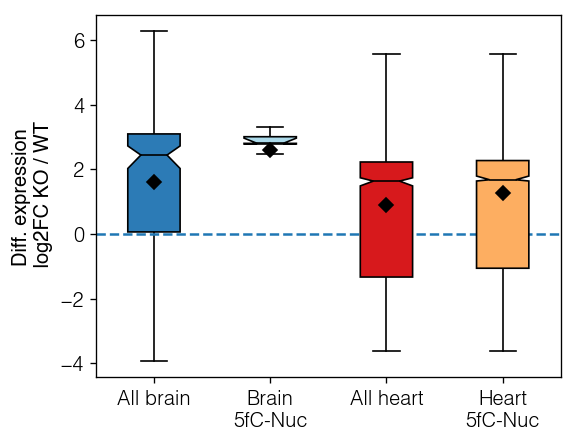

In [18]:
medianprops = dict(color='black')
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='black')
f, ax = plt.subplots(1, 1, sharex=True,
                    figsize=(5,4), dpi=120)
_ = ax.boxplot([list(expr_brain_ko_vs_wt.values()), 
                    logfc_b_5fC_nuc_de, 
                    list(expr_heart_ko_vs_wt.values()), 
                    logfc_h_5fC_nuc_de], 
                medianprops=medianprops, 
               meanprops=meanpointprops,
                showmeans=True, notch=True,
               patch_artist=True, showfliers=False, 
               bootstrap=5000)
names = ["All brain", "Brain\n5fC-Nuc", "All heart", "Heart\n5fC-Nuc"]
colors = ['#2c7bb6', '#abd9e9',"#d7191c", "#fdae61"]
for patch, color in zip(_['boxes'], colors):
    patch.set_facecolor(color)
ax.set_xticklabels(names)
_ = ax.axhline(linestyle="--")
ax.set_ylabel("Diff. expression\n log2FC KO / WT")
plt.savefig("boxplot_DE_wt_ko_5fc.pdf", bbox_inches = 'tight')

In [29]:
_, pval = stats.mannwhitneyu(list(expr_brain_ko_vs_wt.values()), logfc_b_5fC_nuc_de, alternative='less')
print("Pval Brain DE NOT nuc-5fC vs Brain nuc-5fC", pval)
_, pval = stats.mannwhitneyu(list(expr_heart_ko_vs_wt.values()), logfc_h_5fC_nuc_de, alternative="less" )
print("Pval Heart DE NOT nuc-5fC vs Heart nuc-5fC", pval)

Pval Brain DE NOT nuc-5fC vs Brain nuc-5fC 0.00343773369415
Pval Heart DE NOT nuc-5fC vs Heart nuc-5fC 0.0278945331389


# Gene expression 

In [30]:
# Read it from the RNA_seq analysis where we processed everything together
ge = pd.read_table("rpkm_brain_heart_wt_and_ko.txt")

In [31]:
# Average the GE for each subclass
ge["Brain_KO"] = ge[["Brain_KO1","Brain_KO2", "Brain_KO3"]].mean(axis=1)
ge["Brain_WT"] = ge[["Brain_WT1","Brain_WT2", "Brain_WT3"]].mean(axis=1)
ge["Heart_KO"] = ge[["Heart_KO1","Heart_KO2", "Heart_KO3"]].mean(axis=1)
ge["Heart_WT"] = ge[["Heart_WT1","Heart_WT2", "Heart_WT3"]].mean(axis=1)

In [32]:
# Make a ge dictionary for each case
def do_dict_from_ge(pd_obj, col_name):
    dic = pd.Series(np.log(ge[col_name].values), index=ge["gene_name"].str.upper()).to_dict()
    #dic = pd.Series(ge[col_name].values, index=ge["gene_name"].str.upper()).to_dict()
    return dic

In [33]:
ge_dict = {}
for col in ["Brain_KO", "Brain_WT", "Heart_KO", "Heart_WT"]:
    ge_dict.setdefault(col, do_dict_from_ge(ge, col))

In [34]:
# Heart
ge_h_5fC_nuc_ko = list(find_DE_inbed(enhancers_nuc5fc_h_ko, ge_dict["Heart_KO"]))
ge_h_not_5fC_nuc_ko = list(find_DE_inbed(enhancers_not_nuc5fc_h_ko, ge_dict["Heart_KO"]))
ge_h_5fC_nuc_wt = list(find_DE_inbed(enhancers_nuc5fc_h_wt, ge_dict["Heart_WT"]))
ge_h_not_5fC_nuc_wt = list(find_DE_inbed(enhancers_not_nuc5fc_h_wt, ge_dict["Heart_WT"]))
print("Num heart 5fC-Nuc KO", len(ge_h_5fC_nuc_ko))
print("Num heart not 5fC-Nuc KO", len(ge_h_not_5fC_nuc_ko))
print("Num heart 5fC-Nuc WT", len(ge_h_5fC_nuc_wt))
print("Num heart not 5fC-Nuc WT", len(ge_h_not_5fC_nuc_wt))

Num heart 5fC-Nuc KO 26487
Num heart not 5fC-Nuc KO 22429
Num heart 5fC-Nuc WT 83
Num heart not 5fC-Nuc WT 37941


In [35]:
# Brain
ge_b_5fC_nuc_ko = list(find_DE_inbed(enhancers_nuc5fc_b_ko, ge_dict["Brain_KO"]))
ge_b_not_5fC_nuc_ko = list(find_DE_inbed(enhancers_not_nuc5fc_b_ko, ge_dict["Brain_KO"]))
ge_b_5fC_nuc_wt = list(find_DE_inbed(enhancers_nuc5fc_b_wt, ge_dict["Brain_WT"]))
ge_b_not_5fC_nuc_wt = list(find_DE_inbed(enhancers_not_nuc5fc_b_wt, ge_dict["Brain_WT"]))
print("Num brain 5fC-Nuc KO", len(ge_b_5fC_nuc_ko))
print("Num brain not 5fC-Nuc KO", len(ge_b_not_5fC_nuc_ko))
print("Num brain 5fC-Nuc WT", len(ge_b_5fC_nuc_wt))
print("Num brain not 5fC-Nuc WT", len(ge_b_not_5fC_nuc_wt))

Num brain 5fC-Nuc KO 10092
Num brain not 5fC-Nuc KO 21074
Num brain 5fC-Nuc WT 517
Num brain not 5fC-Nuc WT 28525


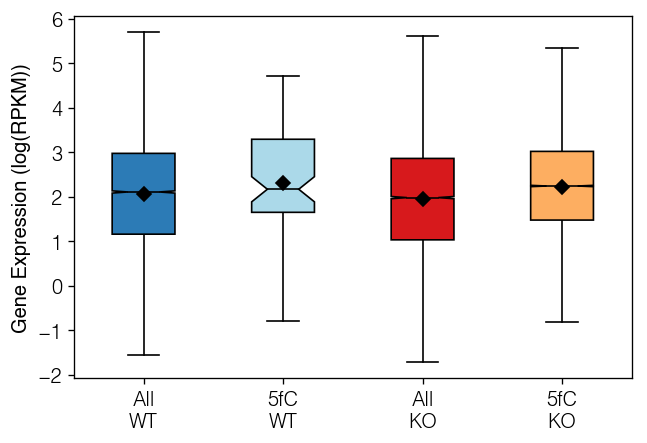

In [36]:
# Plot the distributions
medianprops = dict(color='black')
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='black')
f, ax = plt.subplots(1, 1, sharex=True,
                    figsize=(6,4), dpi=120)
_ = ax.boxplot([list(ge_dict["Heart_WT"].values()),
                 ge_h_5fC_nuc_wt, 
                 list(ge_dict["Heart_KO"].values()),
                 ge_h_5fC_nuc_ko], 
               medianprops=medianprops,
               meanprops=meanpointprops, patch_artist=True, 
                showfliers=False, notch=True, showmeans=True)
names = ["All\nWT", "5fC\nWT", "All\nKO", "5fC\nKO"]
ax.set_ylabel("Gene Expression (log(RPKM))")
colors = ['#2c7bb6', '#abd9e9',"#d7191c", "#fdae61"]
for patch, color in zip(_['boxes'], colors):
    patch.set_facecolor(color)
#ax.set_title("Heart")
ax.set_xticklabels(names)
plt.savefig("boxplot_heart_log_gene_expression_wt_ko_5fc.pdf")

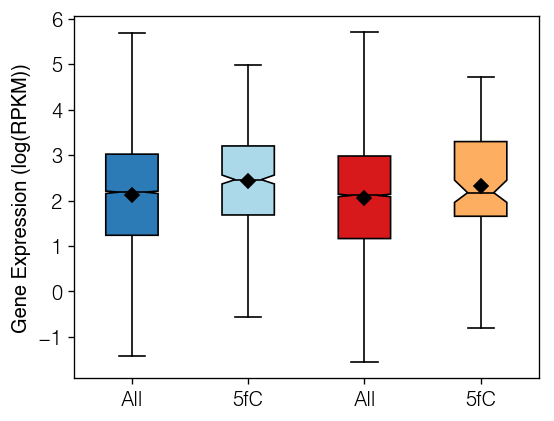

In [37]:
# Combine for gene expression for brain/heart in TDG WT
medianprops = dict(color='black')
meanpointprops = dict(marker='D', markeredgecolor='black',
                      markerfacecolor='black')
f, ax = plt.subplots(1, 1, sharex=True,
                    figsize=(5,4), dpi=120)
_ = ax.boxplot([list(ge_dict["Brain_WT"].values()),
                 ge_b_5fC_nuc_wt, 
                 list(ge_dict["Heart_WT"].values()),
                 ge_h_5fC_nuc_wt], 
                 medianprops=medianprops,
               meanprops=meanpointprops,
               patch_artist=True,
                showfliers=False, notch=True, showmeans=True, 
              bootstrap=5000)
names = ["All", "5fC", "All", "5fC"]
colors = ['#2c7bb6', '#abd9e9',"#d7191c", "#fdae61"]
for patch, color in zip(_['boxes'], colors):
    patch.set_facecolor(color)
ax.set_ylabel("Gene Expression (log(RPKM))")
#ax.set_title("Heart")
ax.set_xticklabels(names)
plt.savefig("boxplot_brain_heart_log_gene_expression_wt_5fc.pdf", bbox_inches = 'tight')


In [39]:
_, pval = stats.mannwhitneyu(list(ge_dict["Brain_WT"].values()), ge_b_5fC_nuc_wt, alternative='less')
print("pval All enhancers expression vs only 5fC-related in brain", pval)
_, pval = stats.mannwhitneyu(list(ge_dict["Heart_WT"].values()), ge_h_5fC_nuc_wt, alternative='less' )
print("pval All enhancers expression vs only 5fC-related in heart", pval)


pval All enhancers expression vs only 5fC-related in brain 3.03964692069e-08
pval All enhancers expression vs only 5fC-related in heart 0.0949819423119


In [26]:
_, pval = stats.mannwhitneyu(list(ge_dict["Brain_WT"].values()), ge_b_5fC_nuc_wt )
print("pval GE Brain WT and 5fC nuc WT", pval)
_, pval = stats.mannwhitneyu(list(ge_dict["Brain_KO"].values()), ge_b_5fC_nuc_ko )
print("pval GE Brain KO vs b 5fC nuc KO", pval)

pval GE Brain WT and 5fC nuc WT 3.03964692069e-08
pval GE Brain KO vs b 5fC nuc KO 8.13351852979e-28
